# Sheet 4: Decision Trees
By: Abdelrahman Mohamed Abdelnabi, 3466

# Book Exercises

## Question 2

                    Y              car = {Sports} ?            N
           Y    Age <= 20    N                               class = H
       class = H         class = L
All nodes have 100% purity

To classify the point $(age=27, Car=Vintage)$ we traverse the tree. First we check if the car is sports, the answer is No, so we go to the right child. The right child is a leaf node with label H so we classify the point as H.

## Question 3
$CART(D_Y, D_N) = 2 \frac{n_Y}{n}\frac{n_N}{n} \sum_{i=1}^k \lvert P(c_i|D_y) - P(c_i|D_n)\rvert$

The value of cart is maximum when the points are partitioned into two equal partitions with each partition having only points from one class. When this happens the value of $2 \frac{n_Y}{n}\frac{n_N}{n}$ is maximum and is equal to $0.5$ and the value of $P(c_1|D_Y) - P(c_1|D_N) = 1-0 = 1$ and the value of $P(c_{-1}|D_Y) - P(c_{-1}|D_N) = 0-1 = -1$. The maximum value of CART is therefore $$0.5\cdot (\lvert1\rvert + \lvert-1\rvert) = 1$$

The minimum value occurs when one of the partitions is empty and the value of $2 \frac{n_Y}{n}\frac{n_N}{n}$ becomes zero. But assuming partitions can not be empty, the minimum can also occur when both partitions have an equal number of points from each class, at which point the probabilities will all be equal to $0.5$ and the value of the $\sum_{i=1}^k \lvert P(c_i|D_y) - P(c_i|D_n)\rvert$ will be zero.

## Question 5

||$A$|$B$|$$AB-B^2$$|Class|
|:---:|:---:|:---:|:---:|:---:|
|$x_1$|$3.5$|$4$|-2|H|
|$x_2$|$2$|$4$|4|H|
|$x_3$|$9.1$|$4.5$|20.70|L|
|$x_4$|$2$|$6$|-24|H|
|$x_5$|$1.5$|$7$|-38.5|H|
|$x_6$|$7$|$6.5$|3.250000|H|
|$x_7$|$2.1$|$2.5$|-1|L|
|$x_8$|$8$|$4$|16|L|

After splitting the data based on the attribute $AB-B^2 \leq 0?$. In the left partition, we have 3 from class H and 1 from class L. In the right partition we have 2 from class H and 2 from class L.
before the split $H(D) = -(\frac{3}{8}\log_2{\frac{3}{8}} + \frac{5}{8}\log_2{\frac{5}{8}}) = 0.954$.

After the split
$$P(L|D_Y) = \frac{1}{1+3} = 0.25$$
$$P(H|D_Y) = \frac{3}{1+3} = 0.75$$
$$P(L|D_N) = \frac{2}{2+2} = 0.5$$
$$P(H|D_N) = \frac{2}{2+2} = 0.5$$

and therefore
$$H(D_Y) = -(0.25\log_2{0.25} + 0.75\log_2{0.75}) = 0.811$$
$$H(D_N) = -(0.5\log_2{0.5} + 0.5\log_2{0.5}) = 1$$
$$H(D_Y,D_N) = \frac{4}{8}\times 0.811 + \frac{4}{8}\times 1 = 0.9055$$

$$Gain = H(D) - H(D_Y,D_N) = 0.954- 0.9055 = 0.0489$$

# Coding Question

## imports and helper methods

In [1]:
import numpy as np
import re
from matplotlib import pyplot as plt
import os
from numpy import linalg
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D
from math import log
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# print images/plots in the notebook itself
%matplotlib inline

In [2]:
def list_to_dict(li):
    dct = {}
    for item in li:
        if item in dct:
            continue
        else:
            dct[item] = []
    return dct

In [3]:
# imports a pgm image into a matrix
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


## importing the dataset

In [4]:
# the images matrix that we will build
# we create a python list and later 
# convert it to a numpy matrix because
# it is faster this way.
images = []
labels = []

# path to dataset
path = '../face recognition assignment/orl_faces'
dirnames = os.listdir(path)
dirnames.remove('README')

# sort directories by number to get the labels vector correct
dirnames.sort(key=lambda f: int(filter(str.isdigit, f)))

idx = 1
# for each folder (person), read his 10 images
for person_dir in dirnames:
    person_dir = os.path.join(path, person_dir)
    for img_file in os.listdir(person_dir):
        img = read_pgm(os.path.join(person_dir, img_file))
        img_vec = np.hstack(img)
        images.append(img_vec)
        labels.append(idx)
    idx += 1

train_data = np.array(images[0::2])
train_data = train_data.reshape(len(train_data), len(train_data[0]))
test_data = np.array(images[1::2])
test_data = test_data.reshape(len(test_data), len(test_data[0]))
train_labels = np.array(labels[0::2])
test_labels = np.array(labels[1::2])

## PCA code from previous assignment

In [5]:
def project(prj_mat, train_data, test_data):
    prj_mat = prj_mat.T

    prj_train = np.dot(train_data, prj_mat)
    prj_test = np.dot(test_data, prj_mat)
    return prj_train, prj_test

def center_data(train_data):
    mean = np.mean(train_data, axis=0)
    centered_data = train_data - mean
    return mean, centered_data

## Leaf Node class

In [6]:
class leaf_node:
    def __init__(self, label, purity):
        self.label = label
        self.purity = purity

## Internal Node class
same as the leaf node but has splitting attribute and splitting value and of course left and right children

In [7]:
class internal_node:
    def __init__(self, purity):
        self.purity = purity
    
    def set_left_child(self, left):
        self.left = left
    def set_right_child(self, right):
        self.right = right
    
    def set_splitter(self, split_attr, split_point):
        self.attr = split_attr
        self.point = split_point
    
    def classify(self, data_point):
        assert len(data_point) > self.attr + 1
        return True if data_point[self.attr] < self.point else False

## method to evaluate numerical attribute
Takes the data, its labels, the number of different classes, and the index of the numerical attribute to evaluate the data at.

Returns a 2-tuples of (best splitting point, the score at the best splitting point)

In [8]:
def evaluate_numeric_attr(data, labels, num_of_classes, attr):
    # sort D on attribute attr
    indices = data[:,attr].argsort()
    data = data[indices]
    labels = labels[indices]
    
    midpoints = set()
    running_count = np.zeros(num_of_classes + 1)
    
    # key: midpoint, value: count for each class at this midpoint
    N_vi = {}

    for j in range(len(data) - 1):
        # increment running count for class of current point
        if j >= len(labels) or labels[j] >= len(running_count):
            print j, labels[j]
        running_count[labels[j]] += 1
        
        # if it is a new midpoint
        if data[j][attr] != data[j+1][attr]:
            v = (data[j][attr] + data[j+1][attr]) / 2
            midpoints.add(v)
            
            # keep count of each class at this midpoint
            N_vi[v] = running_count.copy()

    # count the last point
    running_count[labels[len(data) - 1]] += 1
    
    # now the running count is the total count
    # (we have iterated over all the points)
    total_count = running_count
    
    best_score = -1
    best_v = 0
    
    for v in midpoints:
        counts = N_vi[v]
        score = gain(counts, total_count)
        if score > best_score:
            best_score = score
            best_v = v
    
    return best_v, best_score

## method to calculate the information gain
Used to evaluate splitting points. Higher score is better.

Takes the count of each class at the splitting point, and the total count of each class.

Returns the information gain at this splitting point.

In [9]:
def gain(count_at_midpoint, total_count):
    assert len(count_at_midpoint) == len(total_count)
    H_d = 0
    n = float(sum(total_count))
    
    for c in total_count:
        prob = c/n
        if c == 0:
            continue
        H_d += prob*log(prob, 2)
    H_d *= -1
    
    # calculate H(Dy) and H(Dn)
    H_y = 0
    total = sum(count_at_midpoint)
    for c in count_at_midpoint:
        if c == 0:
            continue
        prob = c/total
        H_y += prob*log(prob, 2)
    H_y *= -1
    
    H_n = 0
    for i in range(len(count_at_midpoint)):
        prob = (total_count[i]- count_at_midpoint[i])/(n - total)
        if prob == 0:
            continue
        H_n += prob*log(prob, 2)
    H_n *= -1
    
    H_y_n = (total/n)*H_y + ((n-total)/n)*H_n
    
    H = H_d - H_y_n
    return H

## Decision Tree class

### methods
- `decision_tree()`: Creates a decision tree model. Constructs a decision tree from the given data and labels. You can also pass the constructor the desired values of eita and pi.
- `classify()`: takes a datapoint to classify, returns the predicted label of the datapoint.

In [10]:
class decision_tree:
    def __init__(self, data, labels, eita=5, pi=0.9, show_score=False):
        self.eita = eita
        self.pi = pi
        num_of_classes = len(set(labels))
        self.root = self.build_decision_tree(data, labels, num_of_classes, eita, pi, show_score)
    
    def classify(self, data_point):
        return self.recursive_classify(self.root, data_point)
    
    def recursive_classify(self, root, data_point):
        if isinstance(root, leaf_node):
            return root.label
        if root.classify(data_point):
            return self.recursive_classify(root.left, data_point)
        return self.recursive_classify(root.right, data_point)
        
    def build_decision_tree(self, data, labels, num_of_classes, eita, pi, show_score):
        assert len(data) == len(labels)
        n = len(data)

        class_data = list_to_dict(labels)
        for i in range(len(data)):
            label = labels[i]
            class_data[label].append(data[i])

        # Convert class-specific subsets to np matrix
        for label in class_data:
            temp = class_data[label]
            class_data[label] = np.array(temp).reshape(len(temp), len(temp[0]))

        # find class with max purity
        purity = 0
        purest_class = -1
        for label in class_data:
            if len(class_data[label]) > purity:
                purity = len(class_data[label])
                purest_class = label
        if n == 0: # shouldn't happen unless a split point didn't split anything
            return leaf_node(-1, 0)
        purity = purity / n

        # stopping condition / base case
        if eita >= n or purity > pi:
            leaf = leaf_node(purest_class, purity)
            return leaf

        split_attr, split_point = -1,-1
        best_score = -1

        # for each attribute
        for attr in range(len(data[0])):
            if type(data[0][attr]) is 'bool':
                continue
            else:
                split, score = evaluate_numeric_attr(data, labels, num_of_classes, attr)
                if show_score:
                    print ("attr: {}, score: {}".format(attr, score))
                if score > best_score:
                    split_attr, split_point = attr, split
                    best_score = score

        data_y = data[data[:,split_attr] < split_point]
        data_n = data[data[:,split_attr] >= split_point]

        label_y = labels[data[:,split_attr] < split_point]
        label_n = labels[data[:,split_attr] >= split_point]

        int_node = internal_node(purity)
        int_node.set_splitter(split_attr, split_point)
        int_node.set_left_child(self.build_decision_tree(data_y, label_y, num_of_classes, eita, pi, show_score))
        int_node.set_right_child(self.build_decision_tree(data_n, label_n, num_of_classes, eita, pi, show_score))

        return int_node

## Testing the model on the orl faces dataset
Takes a decision tree model, the data to test it against, and the labels of the test data.

Returns the a 2-tuples of the form (accuracy, list of classifications) where each classification is 2-tuples of the form (predicted label, actual label)

In [11]:
def test_decision_tree(decision_tree, test_data, test_labels):
    assert len(test_data) == len(test_labels)
    correct = 0
    classifications = []
    for i in range(len(test_data)):
        predicted = decision_tree.classify(test_data[i])
        actual = test_labels[i]
        classifications.append((predicted, actual))

        if predicted == actual:
            correct += 1
            
    accuracy = correct*100.0/len(test_labels)
    return accuracy, classifications

### Reducing the dimensionality of the dataset using PCA

In [12]:
mean, images_centered = center_data(train_data)
covariance = (images_centered.T.dot(images_centered))/len(train_data)

In [13]:
pca_evalues, pca_evectors = linalg.eigh(covariance)
idx = pca_evalues.argsort()[::-1]
pca_evalues = pca_evalues[idx]
pca_evectors = pca_evectors[:,idx]

### projecting to 150 dimensions

In [14]:
prj_mat = np.vstack(pca_evectors.T[0:150])
prj_train, prj_test = project(prj_mat, train_data, test_data)
print "explained variance: {}".format(sum(pca_evalues[0:150])*100/sum(pca_evalues))

explained variance: 97.7879800275


In [15]:
dt = decision_tree(prj_train, train_labels, eita=3, pi = 0.7)

In [16]:
accuracy, classifications = test_decision_tree(dt, prj_test, test_labels)

In [17]:
print "accuracy: {}".format(accuracy)

# uncomment the line below to print the classification errors
# print "errors (predicted label, actual label): {}".format(filter(lambda x: True if x[0] != x[1] else False, classifications))

accuracy: 55.0


### projecting to 100 dimensions

In [18]:
prj_mat = np.vstack(pca_evectors.T[0:100])
prj_train, prj_test = project(prj_mat, train_data, test_data)
print "explained variance: {}".format(sum(pca_evalues[0:100])*100/sum(pca_evalues))

explained variance: 93.4360692052


In [19]:
dt = decision_tree(prj_train, train_labels, eita=3, pi = 0.7)

In [20]:
accuracy, classifications = test_decision_tree(dt, prj_test, test_labels)

In [21]:
print "accuracy: {}".format(accuracy)

# uncomment the line below to print the classification errors
# print "errors (predicted label, actual label): {}".format(filter(lambda x: True if x[0] != x[1] else False, classifications))

accuracy: 55.0


### projecting to 50 dimensions

In [22]:
prj_mat = np.vstack(pca_evectors.T[0:50])
prj_train, prj_test = project(prj_mat, train_data, test_data)
print "explained variance: {}".format(sum(pca_evalues[0:50])*100/sum(pca_evalues))

explained variance: 84.7004512927


In [23]:
dt = decision_tree(prj_train, train_labels, eita=3, pi = 0.7)

In [24]:
accuracy, classifications = test_decision_tree(dt, prj_test, test_labels)

In [25]:
print "accuracy: {}".format(accuracy)

# uncomment the line below to print the classification errors
# print "errors (predicted label, actual label): {}".format(filter(lambda x: True if x[0] != x[1] else False, classifications))

accuracy: 55.0


## Analyzing the results
We notice that the accuracy doesn't change with the increase in the number of dimensions we use to represent the data. This means that all dimensions after the 50th dimension were never used in any node as a splitting attribute. All the nodes used one of the first 50 dimensions to split the data, and so the remaining dimensions are actually useless with respect to the decision tree. They are never used to split the data and therefore they will never change how a point is classified.

But why? why does the decision tree never uses any of dimensions after the 50th dimension. Well, remember that we used PCA to reduce the dimensionality of the data before feeding it the to the tree. PCA projects the data onto a new subspace such that dimensions have the highest variance(in decreasing order). What happens when we try to use an attribute/dimension that has high variance as a splitting attribute? We should get a good split because the data is varying rapidly at this dimension and so it should be easier to find a splitting point. And the opposite is true for dimensions with low variance, the lower the variance the more concentrated the data, and the harder it becomes to split the data while maximizing information gain.

We can actually see a decrease in the score (information gain measure) as we use dimensions with lower variance. To see that we can print the attribute and best score we could find for that attribute.

In [26]:
prj_mat = np.vstack(pca_evectors.T[0:150])
prj_train, prj_test = project(prj_mat, train_data, test_data)

# pass the decision tree the parameter show_score=True
dt = decision_tree(prj_train, train_labels, eita=3, pi = 0.7, show_score=True)

attr: 0, score: 0.868565000806
attr: 1, score: 0.80166272552
attr: 2, score: 0.805438714641
attr: 3, score: 0.593045580937
attr: 4, score: 0.611579351804
attr: 5, score: 0.701820363665
attr: 6, score: 0.628015924761
attr: 7, score: 0.396451494857
attr: 8, score: 0.623149235336
attr: 9, score: 0.626881031271
attr: 10, score: 0.560791707571
attr: 11, score: 0.571409030565
attr: 12, score: 0.497932262933
attr: 13, score: 0.513889727718
attr: 14, score: 0.471053061298
attr: 15, score: 0.518126153727
attr: 16, score: 0.500732136553
attr: 17, score: 0.529642959047
attr: 18, score: 0.562413969249
attr: 19, score: 0.515255694054
attr: 20, score: 0.488255311472
attr: 21, score: 0.522381969423
attr: 22, score: 0.354310923139
attr: 23, score: 0.52466695899
attr: 24, score: 0.463393530842
attr: 25, score: 0.407638207254
attr: 26, score: 0.373455636265
attr: 27, score: 0.385278276148
attr: 28, score: 0.38334927637
attr: 29, score: 0.36763100959
attr: 30, score: 0.401246071151
attr: 31, score: 0.463

We can see a correlation between the score and variance of the dimension. The lower the variance the lower the dimension. And since we use the attribute with the highest score as the splitting attibute and the fact that this attribute with the highest score is always one of the 50 first attributes, we never use any of the dimensions after the 50th dimension.

We can plot the score vs the attribute/dimension number and see the correlation. I just copied the output of the previous cell for the first node and hardcoded it.

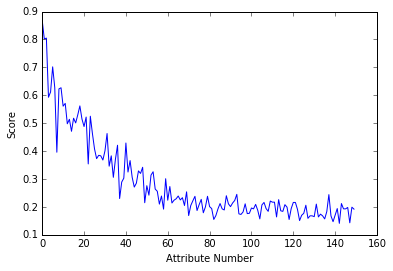

In [31]:
points = [(0,0.869),(1,0.802),(2,0.805),(3,0.593),(4,0.612),(5,0.702),(6,0.628),(7,0.396),(8,0.623),(9,0.627),(10,0.561),
          (11,0.571),(12,0.498),(13,0.514),(14,0.471),(15,0.518),(16,0.501),(17,0.530),(18,0.562),(19,0.515),(20,0.488),
          (21,0.522),(22,0.354),(23,0.525),(24,0.463),(25,0.408),(26,0.373),(27,0.385),(28,0.383),(29,0.368),(30,0.401),
          (31,0.463),(32,0.346),(33,0.383),(34,0.306),(35,0.371),(36,0.421),(37,0.230),(38,0.289),(39,0.303),(40,0.429),
          (41,0.325),(42,0.366),(43,0.306),(44,0.271),(45,0.285),(46,0.329),(47,0.320),(48,0.342),(49,0.215),(50,0.276),
          (51,0.242),(52,0.314),(53,0.326),(54,0.264),(55,0.256),(56,0.210),(57,0.239),(58,0.192),(59,0.301),(60,0.224),
          (61,0.273),(62,0.214),(63,0.224),(64,0.229),(65,0.239),(66,0.225),(67,0.233),(68,0.205),(69,0.254),(70,0.169),
          (71,0.205),(72,0.222),(73,0.238),(74,0.187),(75,0.208),(76,0.227),(77,0.179),(78,0.200),(79,0.238),(80,0.201),
          (81,0.194),(82,0.155),(83,0.169),(84,0.193),(85,0.212),(86,0.193),(87,0.189),(88,0.240),(89,0.211),(90,0.201),
          (91,0.214),(92,0.223),(93,0.245),(94,0.175),(95,0.173),(96,0.182),(97,0.211),(98,0.176),(99,0.177),(100,0.196),
          (101,0.193),(102,0.209),(103,0.188),(104,0.157),(105,0.207),(106,0.216),(107,0.194),(108,0.184),(109,0.221),
          (110,0.217),(111,0.217),(112,0.164),(113,0.226),(114,0.186),(115,0.184),(116,0.208),(117,0.199),(118,0.155),
          (119,0.194),(120,0.216),(121,0.216),(122,0.191),(123,0.151),(124,0.170),(125,0.177),(126,0.206),(127,0.159),
          (128,0.168),(129,0.168),(130,0.165),(131,0.210),(132,0.164),(133,0.174),(134,0.168),(135,0.157),(136,0.183),
          (137,0.244),(138,0.168),(139,0.147),(140,0.170),(141,0.194),(142,0.141),(143,0.212),(144,0.193),(145,0.193),
          (146,0.198),(147,0.143),(148,0.199),(149,0.192)]
attr = [x[0] for x in points]
score = [x[1] for x in points]
plt.plot(attr,score)
plt.xlabel('Attribute Number')
plt.ylabel('Score')
plt.show()

The correlation is true for large amount of points. It doesn't hold true in deeper nodes where the number of points is small.

## Trying Sci-kit learn random forest classifier

### using all the dimensions

In [28]:
trees = [10, 20, 30, 100, 300]
criterion = ['gini', 'entropy']
for t in trees:
    for c in criterion:
        clf = RandomForestClassifier(n_estimators=t, criterion=c)
        clf = clf.fit(train_data, train_labels)
        correct = 0
        for i in range(len(test_data)):
            predicted = clf.predict(test_data[i])
            actual = test_labels[i]
            
            if predicted == actual:
                correct += 1
        accuracy = correct*100.0/len(test_labels)
        print ("number of trees: {}, criterion: {} => accuracy: {}".format(t, c, accuracy))

number of trees: 10, criterion: gini => accuracy: 75.0
number of trees: 10, criterion: entropy => accuracy: 73.5
number of trees: 20, criterion: gini => accuracy: 83.0
number of trees: 20, criterion: entropy => accuracy: 87.5
number of trees: 30, criterion: gini => accuracy: 87.5
number of trees: 30, criterion: entropy => accuracy: 92.0
number of trees: 100, criterion: gini => accuracy: 93.5
number of trees: 100, criterion: entropy => accuracy: 93.5
number of trees: 300, criterion: gini => accuracy: 95.0
number of trees: 300, criterion: entropy => accuracy: 95.0


### using the first 100 principal components

In [29]:
prj_mat = np.vstack(pca_evectors.T[0:100])
prj_train, prj_test = project(prj_mat, train_data, test_data)

In [30]:
for t in trees:
    for c in criterion:
        clf = RandomForestClassifier(n_estimators=t, criterion=c)
        clf = clf.fit(prj_train, train_labels)
        correct = 0
        for i in range(len(test_data)):
            predicted = clf.predict(prj_test[i])
            actual = test_labels[i]
            
            if predicted == actual:
                correct += 1
        accuracy = correct*100.0/len(test_labels)
        print ("number of trees: {}, criterion: {} => accuracy: {}".format(t, c, accuracy))

number of trees: 10, criterion: gini => accuracy: 60.5
number of trees: 10, criterion: entropy => accuracy: 55.0
number of trees: 20, criterion: gini => accuracy: 72.5
number of trees: 20, criterion: entropy => accuracy: 73.5
number of trees: 30, criterion: gini => accuracy: 80.0
number of trees: 30, criterion: entropy => accuracy: 85.0
number of trees: 100, criterion: gini => accuracy: 89.0
number of trees: 100, criterion: entropy => accuracy: 92.0
number of trees: 300, criterion: gini => accuracy: 91.5
number of trees: 300, criterion: entropy => accuracy: 93.0
